<a href="https://colab.research.google.com/github/Daprosero/Procesamiento-digital-de-im-genes/blob/main/Clase%208/Introducci%C3%B3n_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción a Tensorflow

# Introducción a las redes neuronales profundas

- Se presentan los principios básicos de funcionamiento de las redes neuronales a partir del perceptrón simple hasta perceptrones multicapa.

- Se implementan arquitecturas secuenciales utilizando la librería [TensorFlow](https://www.tensorflow.org/overview?hl=es-419) y la [API Keras](https://keras.io/).

## Perceptrón

- El perceptrón presenta un modelo lineal de la forma:

$$\hat{y} = {\rm{sign}}(\mathbf{w}^\top \mathbf{x}) $$

- Para optimizarlo, se plantea un algoritmo de gradiente descendiente estocástico:

$$\mathbf{w}^* = \arg\max_{\mathbf{w}} - \sum_{\mathbf{x}_n\in \mathbf{X}}\langle \mathbf{w}^\top \mathbf{x}_n ,y_n\rangle$$

$$\mathbf{w}_i =\mathbf{w}_{i-1}-\eta_i \mathbf{x}_ny_n$$

donde $\mathbf{x}_n,\mathbf{w}\in\mathbb{R}^P$ corresponde a la $n$-ésima muestra y al vector de pesos; $y_n\in\{-1,+1\}$ son las etiquetas objetivo, y $\eta_i\in \mathbb{R}^+$ es el hiperparámetro tasa de aprendizaje (learning rate).

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X    = iris.data[:, (2, 3)]  # petal length, petal width
y    = (iris.target == 0).astype(int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])
print(X.shape)
print(y.shape)

(150, 2)
(150,)


In [2]:
y_pred

array([1])

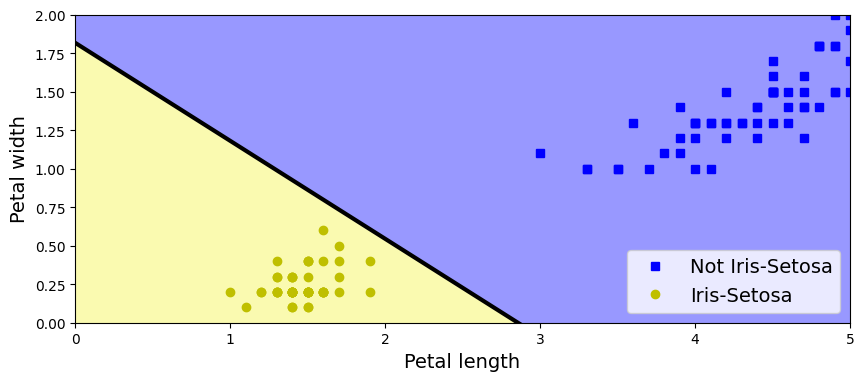

In [3]:
# Graficar fronteras de decisión
#---------------------------
%matplotlib inline
import matplotlib.pyplot as plt

a      = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b      = -per_clf.intercept_ / per_clf.coef_[0][1]
axes   = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new     = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz        = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

#save_fig("perceptron_iris_plot")
plt.show()

El **algoritmo de aprendizaje** de Perceptron se parece mucho al **SGD**. De hecho, la clase de *Perceptron* de Scikit-Learn es equivalente a usar *SGDClassifier* con los siguientes hiperparámetros:
- *loss*          = "perceptron",
- *learning_rate* = "constant",
- *eta0*          = 1 (la tasa de aprendizaje) y
- *penalty*       = "None" (sin regularización).

- Tengamos en cuenta que, al **contrario de los clasificadores de regresión logística**, los perceptrones **no generan una probabilidad de clase; más bien, solo hacen predicciones basadas en un umbral de decisión - distancia a la frontera**.

- Esta es una de las buenas razones para preferir la Regresión logística sobre los Perceptrones.

## Funciones de activación

- En general, un modelo de redes neuronales profundas, se pueden ver como una función compuesta, mediante productos lineales en cascada con funciones de activación no lineal.

- La función signo y la función escalón, presentan discontinuidades de primer orden, lo que inestabiliza sus gradientes.

- Por ende, se prefiere trabajar con funciones sigmoide, relu, y tanh:

  $${\rm{sigmoid}}(x)=\frac{1}{1+e^{-x}}$$

  $${\rm{relu}}(x)=\max(0,x)$$

  $${\rm{tanh}}(x)=\frac{e^x-e^{-x}}{e^x+e^{-x}}$$


#Construyendo un regresor

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Parámetros originales (w0, w1): [-1, 0.5]
Parámetros estimados (w0, w1): [-0.49999976, 0.54991645]


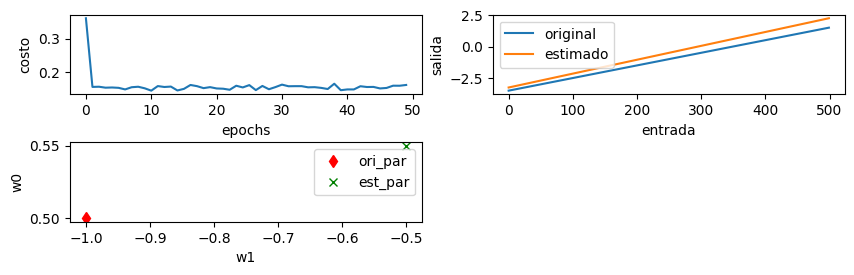

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Datos de ejemplo
N = 500
x = np.linspace(-5, 5, N)
w1 = 0.5
w0 = -1

# Crear datos de entrada y salida
Xdata = np.c_[x.reshape(-1, 1), np.ones((N, 1))]
w = np.array([w1, w0]).reshape(-1, 1)
y = Xdata.dot(w)
var = 0.1
noise = np.sqrt(var)*np.random.randn(N)
yn = y #+ noise#np.random.randn(N, 1)  # Agregar ruido

# Definir el modelo secuencial con una capa lineal
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, input_dim=2)  # Dos características: x y un término constante
])

# Compilar el modelo con la función de costo MSE
lr = 0.05
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr), loss='mae')

# Entrenamiento
epochs = 50
batch_size = 8

history = model.fit(Xdata, yn, epochs=epochs, batch_size=batch_size, verbose=0)

# Obtener los parámetros estimados (los pesos y el sesgo)
weights, bias = model.layers[0].get_weights()
final_W = weights[0, 0]
final_b = bias[0]

print("Parámetros originales (w0, w1):", [w0, w1])
print("Parámetros estimados (w0, w1):", [final_b, final_W])

# Visualización
plt.figure(figsize=(10, 6))

plt.subplot(421)
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('costo')

plt.subplot(422)
plt.plot(y, label='original')
plt.plot(Xdata.dot(np.array([final_W, final_b]).reshape(-1, 1)), label='estimado')
plt.xlabel('entrada')
plt.ylabel('salida')
plt.legend()

plt.subplot(423)
plt.plot(w0, w1, 'rd', label='ori_par')
plt.plot(final_b, final_W, 'gx', label='est_par')
plt.xlabel('w1')
plt.ylabel('w0')
plt.legend()

plt.subplots_adjust(wspace=0.2, hspace=0.6)
plt.show()


# Construyendo un clasificador

Parámetros originales (w0, w1): [-1, 0.5]
Parámetros estimados (w0, w1): [-0.99996614, 0.49999368]
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


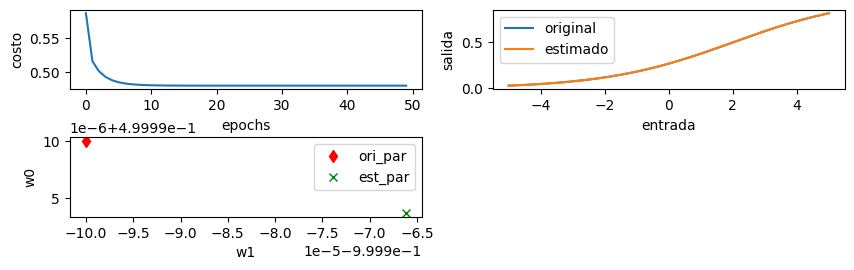

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Datos de ejemplo
N = 500
x = np.linspace(-5, 5, N)
w1 = 0.5  # Cambiamos w1 para obtener valores en el rango [0, 1]
w0 = -1


Xdata = np.c_[x.reshape(-1, 1), np.ones((N, 1))]
w = np.array([w1, w0]).reshape(-1, 1)
Z = Xdata.dot(w)
A = tf.keras.activations.sigmoid(Z)

y=A


# Crear datos de entrada y salida con ruido
#noise = np.random.randn(N)
#y = w1 * x + w0  #noise

# Definir el modelo secuencial con una capa lineal
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1,activation='sigmoid', input_dim=1)
])

# Compilar el modelo
lr = 0.1
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento
epochs = 50
batch_size = 32

history = model.fit(x, y, epochs=epochs, batch_size=batch_size, verbose=0)

# Obtener los parámetros estimados
weights, bias = model.layers[0].get_weights()
final_W = weights[0, 0]
final_b = bias[0]

print("Parámetros originales (w0, w1):", [w0, w1])
print("Parámetros estimados (w0, w1):", [final_b, final_W])

# Visualización
plt.figure(figsize=(10, 6))

plt.subplot(421)
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('costo')

plt.subplot(422)
plt.plot(x, y, label='original')
plt.plot(x, model.predict(x), label='estimado')
plt.xlabel('entrada')
plt.ylabel('salida')
plt.legend()

plt.subplot(423)
plt.plot(w0, w1, 'rd', label='ori_par')
plt.plot(final_b, final_W, 'gx', label='est_par')
plt.xlabel('w1')
plt.ylabel('w0')
plt.legend()

plt.subplots_adjust(wspace=0.2, hspace=0.6)
plt.show()


#Construyendo un clasificador de imágenes

In [6]:
import tensorflow as tf
from tensorflow import keras

In [7]:
tf.__version__

'2.17.1'

- Comencemos cargando el conjunto de datos **Fashion MNIST**.

- Keras tiene una serie de funciones para cargar conjuntos de datos populares en *keras.datasets*.

- El conjunto de datos ya está dividido entre un **conjunto de entrenamiento** y un **conjunto de prueba**, pero puede ser útil dividir aún más el conjunto de entrenamiento para tener un **conjunto de validación**:

In [8]:
fashion_mnist = keras.datasets.fashion_mnist #cargar fashion mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
X_train_full.shape

(60000, 28, 28)

In [10]:
X_train_full.dtype

dtype('uint8')

- Dividamos el **conjunto de entrenamiento** completo en un **conjunto de validación** y un conjunto de entrenamiento (*más pequeño*) mediante la estrategia de validación HoldOut.

- También **escalamos las intensidades de píxeles hasta el rango 0-1** y las convertimos en flotantes, dividiéndolas por 255.

In [11]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

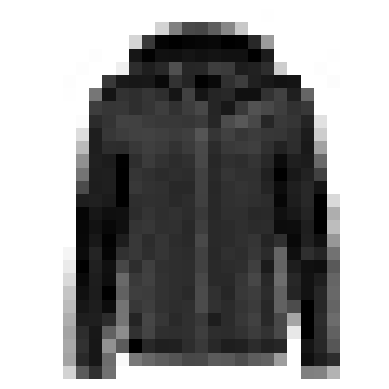

In [12]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [13]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [14]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [15]:
class_names[y_train[0]]

'Coat'

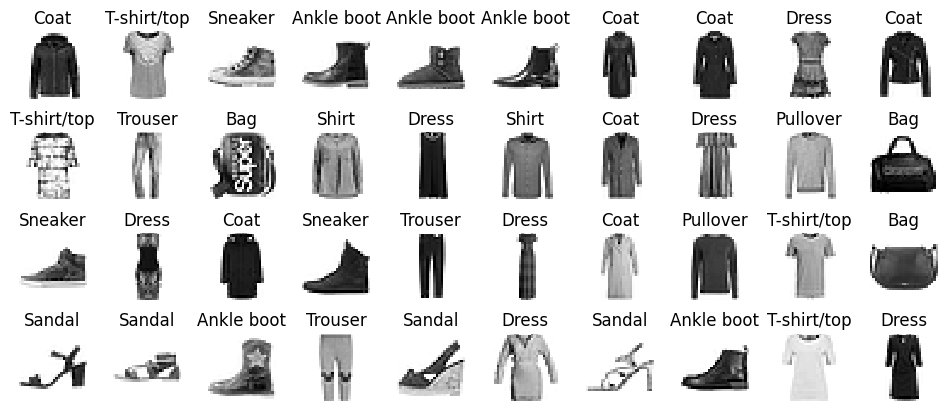

In [16]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [17]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))#capa de aplanado->convierte imagen en vector
model.add(keras.layers.Dense(300, activation="relu"))#capa densa con 300 neuronas y función de activación relu
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))#la capa de salida utiliza una softmax

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Veamos este código línea por línea:
- La primera línea crea un modelo secuencial. Este es el tipo más simple de modelo Keras, para redes neuronales que están compuestas de una sola pila de capas, conectadas secuencialmente. Esto se llama la **API secuencial**.

- Luego, construimos la primera capa y la agregamos al modelo. Es una capa Flatten cuyo papel es simplemente convertir cada imagen de entrada en una matriz 1D. Alternativamente, puede agregar un keras.layers.InputLayer como la primera capa, estableciendo $shape = [28,28]$.

- A continuación, agregamos una capa oculta densa con 300 neuronas. Utilizará la función de activación ReLU. Cada capa densa gestiona su propia matriz de peso, que contiene todos los pesos de conexión entre las neuronas y sus entradas. También gestiona un vector de términos de sesgo (uno por neurona).

- A continuación, agregamos una segunda capa oculta densa con 100 neuronas, que también utiliza la función de activación ReLU.

- Finalmente, agregamos una capa de salida densa con 10 neuronas (una por clase), usando la función de activación softmax (porque las clases son exclusivas).

**Nota**: La activación softmax se puede entender como una generalización de la sigmoid para problemas multiclase, para estimar la probabilidad de membresia $\hat{p}(A_c|\mathbf{x})$:

$${\rm{softmax}}(\mathbf{z})= \left\{\sigma({z}_c)={e^{z_c}}/{\sum\nolimits_{k=1}^C e^{z_k}}\right\}$$
donde $\sigma(z_c)\in[0,1]$ y $\sum_{c=1}^C \sigma(z_c)=1$.



In [18]:
keras.backend.clear_session() #se sugiere limpiar la sesión para liberar los grafos computacionales
np.random.seed(42) #se fija semilla de numpy y tf
tf.random.set_seed(42)

In [19]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

# Modelo y optimización en aprendizaje profundo

- En general, un modelo de aprendizaje profundo se puede escribir como una función compuesta de la forma:

$$\hat{y}=(f_L\circ f_{L-1}\circ\cdots\circ f_1)(\mathbf{x})$$

donde $L$ representa el número de capas y:

$$\mathbf{z}_l=f_l(\mathbf{z}_{l-1})=\varphi(\mathbf{z}_{l-1}\mathbf{W}_{l}+\mathbf{b}_l)$$
donde $\varphi(\cdot)$ es una función de activación, $\mathbf{W}_{l}\in\mathbb{R}^{Q_{l-1}\times Q_{l}},$ $\mathbf{b}_{l}\in\mathbb{R}^{Q_{l}},$ $\mathbf{z}_l\in\mathbb{R}^{Q_l}$ y $Q_l$ representa la cantidad de neuronas en la $l$-ésima capa.

- A partir del modelo planteado, se puede generar el siguiente problema de optimización:

$$\theta^* = \arg\min_{\theta} \mathbb{E}\{\mathcal{L}(y_n,\hat{y}_n|\theta): \forall n \in \{1,2,\dots,N\}\}$$
donde $\theta = \{\mathbf{W}_l,\mathbf{b}_l\}^L_{l=1}$ contiene el set de parámetros de la red y $\mathcal{L}(\cdot,\cdot|\theta)$ es una función de costo dada.



In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

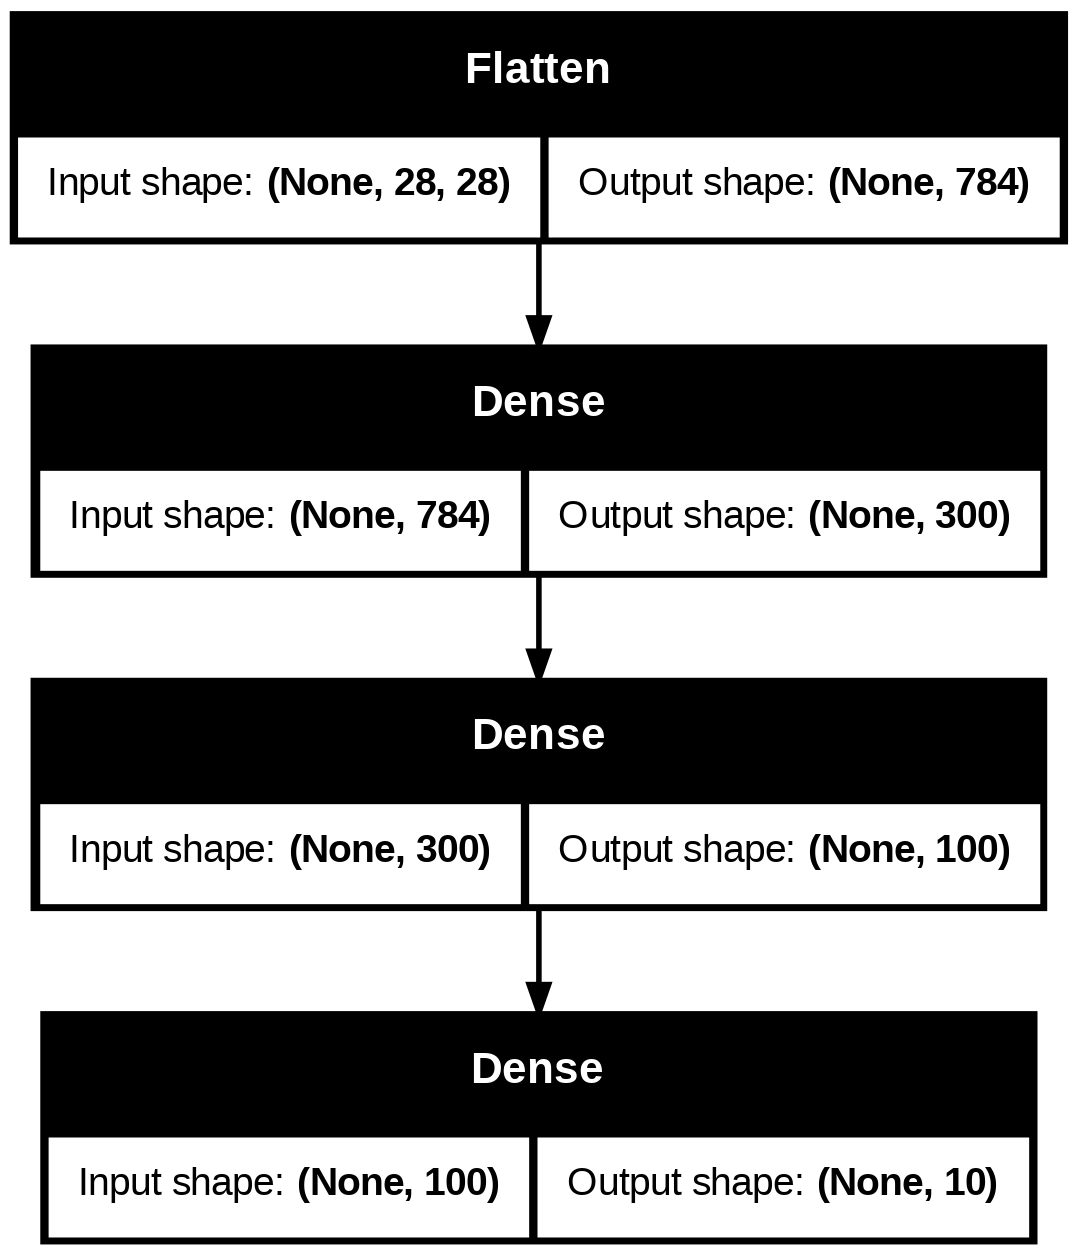

In [21]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

In [22]:
hidden1 = model.layers[1] #acceder a la primera capa densa
hidden1.name

'dense'

In [23]:
model.get_layer(hidden1.name) is hidden1

True

In [24]:
weights, biases = hidden1.get_weights()

In [25]:
weights

array([[ 0.06610306,  0.05265133,  0.05497789, ..., -0.00157487,
         0.0284829 , -0.06555083],
       [-0.01232006,  0.04345485,  0.01649635, ..., -0.03598658,
        -0.07032513, -0.01313926],
       [ 0.0015254 ,  0.00744265, -0.07287771, ..., -0.04382383,
         0.04953518, -0.02579742],
       ...,
       [ 0.02947713,  0.04918627, -0.07387635, ...,  0.05904263,
         0.00337793, -0.03377965],
       [ 0.00245487, -0.04645542, -0.03513817, ..., -0.05231509,
         0.01996055, -0.07218678],
       [-0.06786322, -0.00863874,  0.06617033, ..., -0.04463344,
        -0.0137509 ,  0.04153494]], dtype=float32)

In [26]:
weights.shape

(784, 300)

In [27]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [28]:
biases.shape

(300,)

### Compilando el modelo

- Después de crear un modelo, debe llamar a su método *compile()* para especificar la función de pérdida y el optimizador a utilizar.

- Opcionalmente, también puede especificar una lista de métricas adicionales para calcular durante el entrenamiento y la evaluación.

- En general, la función de costo se elige en términos de la tarea (rango de la función), y se buscan funciones de costo suaves, que no tengan problemas con sus derivadas, con el objetivo de aplicar gradiente descendiente por mini-lotes mediante el algoritmo de backpropagation.


- **Esquema general de aprendizaje por mini-lotes:**

![minibatch](https://github.com/amalvarezme/AnaliticaDatos/blob/master/5_Aprendizaje_Profundo/minibatch.png?raw=1)

*Nota:* en general las muestras en un lote se escogen de forma aleatoria.

- **Ilustración algoritmo backpropagation:**

![gifbp](https://thumbs.gfycat.com/FickleHorribleBlackfootedferret-small.gif)

In [29]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

- Keras proporciona varios tipos de [funciones de costo](https://keras.io/api/losses/) ya implementadas.

- Para tareas de regresión es común trabajar con el error cuadrático medio y el error absoluto medio:

$$mse(\mathbf{y}_n,\hat{\mathbf{y}}_n)= \|\mathbf{y}_n-\hat{\mathbf{y}}_n\|_2$$

$$mae(\mathbf{y}_n,\hat{\mathbf{y}}_n)= \|\mathbf{y}_n-\hat{\mathbf{y}}_n\|_1$$

- Para tareas de clasificación, es común trabajar con medidas de información, evitando las medidas clasicas de acierto (conteos) basadas en la función delta (problemas en las derivadas).

- En este sentido, la cross-entropia es ampliamente usada (tenga encuenta que Keras provee cross entropia binaria y categórica, esta última en sus versiones sparse - codificación 1 C, o no sparse - codificación ordinal de las salidas):

$$H(\mathbf{y}_n,\hat{\mathbf{y}}_n)= -\frac{1}{N}\sum^N_{n=1}\sum^C_{c=1}y_{n,c}\log(\hat{y}_{n,c})$$

donde $y_{n,c}\in \mathbf{y}$ es la etiqueta real de la muestra $n$ en la clase $c$ en codificación 1-C,  $\hat{y}_{n,c}\in \hat{\mathbf{y}}$ es la etiqueta estimada de la muestra $n$ en la clase $c$. Note que $\hat{\mathbf{y}},{\mathbf{y}}\in[0,1]^C$, y $\sum_c\hat{y}_{n,c} = \sum_c y _{n,c} = 1.$

## Entrenando y evaluando el modelo
Ahora el modelo está listo para ser entrenado. Para esto, simplemente necesitamos llamar a su método *fit()*.
- Le pasamos las características de entrada (X_train) y las clases de destino (y_train), así como la cantidad de épocas para entrenar (o de lo contrario, sería predeterminado a solo 1, lo que definitivamente no sería suficiente para converger en una buena solución).
- También pasamos un conjunto de validación (esto es opcional): Keras medirá la pérdida y las métricas adicionales en este conjunto al final de cada época, lo cual es muy útil para ver qué tan bien se desempeña realmente el modelo.
- **NOTA:** si el rendimiento en el entrenamiento es mucho mejor que en el conjunto de validación, su modelo probablemente esté sobreajustando el conjunto de entrenamiento (o hay un error, como una falta de coincidencia de datos entre el conjunto de entrenamiento y el conjunto de validación).


**Nota**: El paquete Tensorflow permite trabajar mediante grafos computacionales optimizados mediante [diferenciación automática](https://github.com/amalvarezme/AnaliticaDatos/blob/master/5_Aprendizaje_Profundo/2_Autodiff.pdf), lo que favorece su escalamiento a grandes cantidades de datos (mediante gradiente descendiente por mini-lotes) y de parámetros.

In [30]:
history = model.fit(X_train, y_train, epochs=30, batch_size =64,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
860/860 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6226 - loss: 1.2151 - val_accuracy: 0.7978 - val_loss: 0.5986
Epoch 2/30
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8082 - loss: 0.5704 - val_accuracy: 0.8200 - val_loss: 0.5133
Epoch 3/30
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8257 - loss: 0.4980 - val_accuracy: 0.8332 - val_loss: 0.4766
Epoch 4/30
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8370 - loss: 0.4626 - val_accuracy: 0.8430 - val_loss: 0.4527
Epoch 5/30
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8437 - loss: 0.4398 - val_accuracy: 0.8476 - val_loss: 0.4372
Epoch 6/30
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8499 - loss: 0.4231 - val_accuracy: 0.8524 - val_loss: 0.4243
Epoch 7/30
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8551 - loss: 0.4097 - val_accuracy: 0.8568 - val_loss: 0.4127
Epoch 8/30
860/860 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8596 - loss: 0.3984 - val_accuracy: 0.

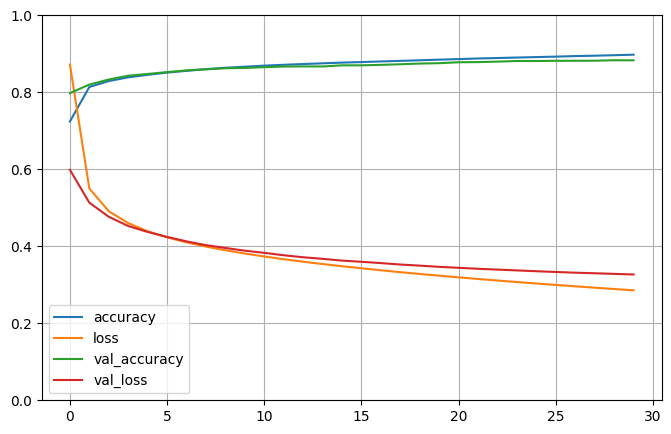

In [31]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")
plt.show()

In [32]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8687 - loss: 0.3683


[0.36991754174232483, 0.8676999807357788]

In [33]:
X_new = X_test[:100]
y_proba = model.predict(X_new)
y_proba.round(2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.07, 0.  , 0.89],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.04, 0.  , 0.05, 0.  , 0.02, 0.  , 0.9 , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.  , 0.97, 0.  , 0.02, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.  , 0.13, 0.  , 0.86, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.98, 0.  , 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.1 , 0.  , 0.88, 0.  , 0.02, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.98, 0.  , 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.07, 0.  , 0.66, 0.  , 0.19, 0.08, 0.  ],
       [0.  , 0.01, 0.  , 0.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.12, 0.  , 0.

In [34]:
np.argmax(y_proba.round(2),axis=1)==y_test[:100]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False,  True, False,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True, False,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [35]:
y_pred = model.predict(X_new).argmax(axis=1) #podemos utilizar argmax para estimar la salida ordinal
y_pred

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 2, 8, 0, 2, 5,
       7, 5, 1, 2, 6, 6, 9, 6, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 6, 7,
       6, 7, 2, 1, 2, 6, 4, 2, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5, 1, 1,
       2, 4, 7, 8, 7, 0, 2, 6, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2,
       0, 2, 5, 3, 6, 7, 1, 8, 0, 1, 4, 2])

In [36]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt', 'Trouser',
       'Coat', 'Shirt', 'Sandal', 'Sneaker', 'Coat', 'Sandal', 'Sandal',
       'Dress', 'Coat', 'Trouser', 'Pullover', 'Pullover', 'Bag',
       'T-shirt/top', 'Pullover', 'Sandal', 'Sneaker', 'Sandal',
       'Trouser', 'Pullover', 'Shirt', 'Shirt', 'Ankle boot', 'Shirt',
       'Bag', 'Bag', 'Dress', 'Dress', 'Bag', 'T-shirt/top', 'Sneaker',
       'Sandal', 'Sneaker', 'Ankle boot', 'Shirt', 'Trouser', 'Shirt',
       'Sneaker', 'Shirt', 'Sneaker', 'Pullover', 'Trouser', 'Pullover',
       'Shirt', 'Coat', 'Pullover', 'Sandal', 'Bag', 'Pullover',
       'Pullover', 'Bag', 'Coat', 'Bag', 'T-shirt/top', 'Sneaker',
       'Sneaker', 'Bag', 'Sandal', 'Trouser', 'Trouser', 'Pullover',
       'Coat', 'Sneaker', 'Bag', 'Sneaker', 'T-shirt/top', 'Pullover',
       'Shirt', 'Pullover', 'Dress', 'Trouser', 'Pullover', 'Bag', 'Coat',
       'Trouser', 'Bag', 'Sandal', 'Ankle boot', 'Sandal', 'T-shirt/top',
       'Dress

# Regresión MLP

- Podemos utilizar un esquema de aprendizaje profundo, fijando la salida en activación lineal o ReLU para trabajar un problema de regresión.

- Carguemos, dividamos y escalemos el conjunto de datos de [vivienda de California](https://www.kaggle.com/camnugent/california-housing-prices):

In [37]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

In [39]:
model = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(10, activation="relu"),

    keras.layers.Dense(1) #se fija una única con activacion lineal
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(1e-3))
history  = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new    = X_test[:3]
y_pred   = model.predict(X_new)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.4520 - val_loss: 1.4807
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6882 - val_loss: 0.8479
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5852 - val_loss: 0.7382
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5300 - val_loss: 0.6570
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4878 - val_loss: 0.5925
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4575 - val_loss: 0.5508
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4365 - val_loss: 0.5274
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4217 - val_loss: 0.5048
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4107 - val_loss: 0.4912
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4020 - val_loss: 0.4734
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3948 - val_loss: 0.4626
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


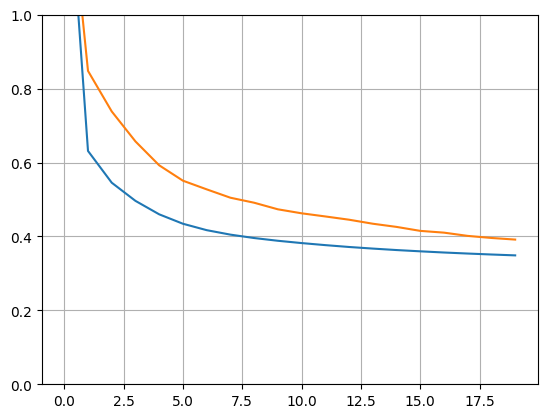

In [40]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [41]:
y_pred,y_test[:3]

(array([[0.63794386],
        [1.7045857 ],
        [4.0298214 ]], dtype=float32),
 array([0.477  , 0.458  , 5.00001]))

# API FUNCIONAL
Como puede ver, la API secuencial es **bastante fácil de usar**. Sin embargo, aunque los modelos secuenciales son extremadamente comunes, a veces es útil construir redes neuronales con topologías más complejas, o con múltiples entradas o salidas. Para este propósito, Keras ofrece la **API funcional**.

In [42]:
train, test = tf.keras.datasets.fashion_mnist.load_data()
images, labels = train
Xtrain, ytrain = train
Xtrain = Xtrain/255 # tipo flotante, normalizados de 0 a 1
Xtest, ytest = test
Xtest = Xtest/255 # tipo flotante, normalizados de 0 a 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ entrada (InputLayer)                 │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ h1 (Dense)                           │ (None, 200)                 │         157,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ h2 (Dense)                           │ (None, 50)                  │          10,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │             510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 167,560 (654.53 KB)

 Trainable params: 167,560 (654.53 KB)

 Non-trainable params: 0 (0.00 B)

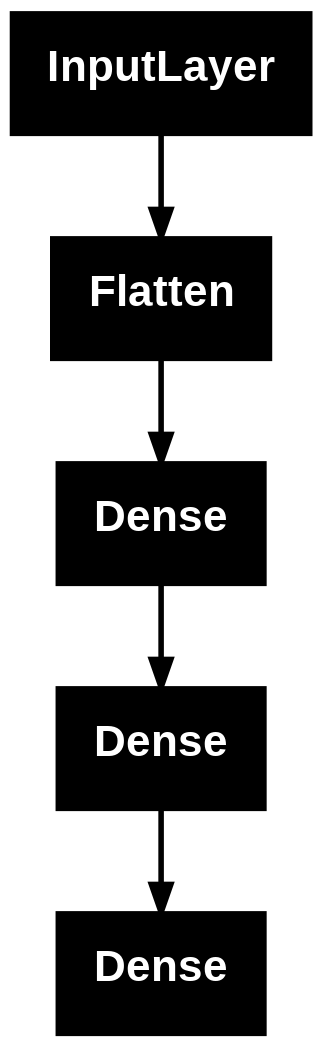

In [43]:
#arquitectura funcional
#capa de entrada
input_l = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2]), name='entrada')
#capa de aplanamiento de las imágenes
flatten = tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2]))(input_l)#argumento de entrada
#capas densas
h1 = tf.keras.layers.Dense(200,activation='tanh',name='h1')(flatten)#argumento de entrada
h2 = tf.keras.layers.Dense(50,activation='tanh',name='h2')(h1)
#capa de salida
output = tf.keras.layers.Dense(10,activation="softmax",name='output')(h2)
#crear modelo según conexiones tipo funcionales
model_fun = tf.keras.Model(inputs=input_l,outputs=output)

#resumen y gráfica del modelo
model_fun.summary()
tf.keras.utils.plot_model(model_fun)


# La API funcional permite realizar conexiones más flexibles

- En el siguiente ejemplo se crea un modelo con una entrada y dos salidas con interconexiones flexibles:

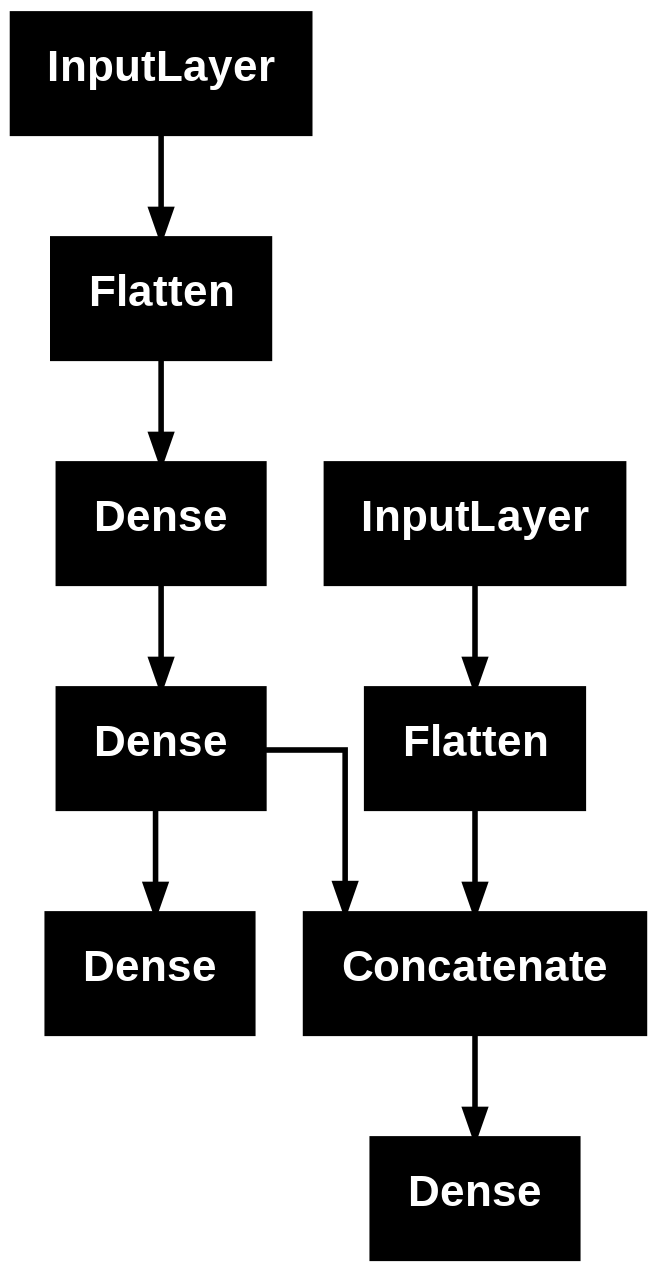

In [44]:
#arquitectura funcional 2
tf.keras.backend.clear_session()
input_l = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2]), name='entrada1')
input_2 = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2]), name='entrada2')
flatten = tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2]))(input_l)
flatten2 = tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2]))(input_2)

h1 = tf.keras.layers.Dense(200,activation='tanh',name='h1')(flatten)
h2 = tf.keras.layers.Dense(50,activation='tanh',name='h2')(h1)
#capa que concatena caracterísitacas extraídas en h2 con imágenes de entrada
concat = tf.keras.layers.concatenate([h2,flatten2])
#se crean dos salidas:
output_A = tf.keras.layers.Dense(10,activation="softmax",name='outputA')(concat)#desde concatenación
output_B = tf.keras.layers.Dense(10,activation="softmax",name='outputB')(h2)#desde h2
#las entradas y salidas se ingresan como listas
model_fun = tf.keras.Model(inputs=[input_l,input_2],outputs=[output_A, output_B])
#model_fun.summary()
tf.keras.utils.plot_model(model_fun)

In [45]:
model_fun.compile(loss=["sparse_categorical_crossentropy","sparse_categorical_crossentropy"], #custom_loss(),#custom_loss(),#"sparse_categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy","accuracy"]) #f1, precision, recall, crossentropy

In [46]:
history = model_fun.fit([Xtrain,Xtrain], [ytrain,ytrain] , epochs=10,batch_size=64, # 32, 64, 128, 256
                    validation_split=0.3) # se fija el conjunto de validación como el 20% del de train

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 1.5062 - outputA_accuracy: 0.7198 - outputA_loss: 0.8176 - outputB_accuracy: 0.7615 - outputB_loss: 0.6886 - val_loss: 0.8745 - val_outputA_accuracy: 0.8382 - val_outputA_loss: 0.4432 - val_outputB_accuracy: 0.8440 - val_outputB_loss: 0.4304
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8150 - outputA_accuracy: 0.8516 - outputA_loss: 0.4117 - outputB_accuracy: 0.8525 - outputB_loss: 0.4033 - val_loss: 0.7729 - val_outputA_accuracy: 0.8581 - val_outputA_loss: 0.3915 - val_outputB_accuracy: 0.8620 - val_outputB_loss: 0.3804
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7270 - outputA_accuracy: 0.8676 - outputA_loss: 0.3681 - outputB_accuracy: 0.8714 - outputB_loss: 0.3589 - val_loss: 0.7253 - val_outputA_accuracy: 0.8683 - val_outputA_loss: 0.3666 - val_outputB_accuracy: 0.8703 - val_outputB_loss: 0.3576
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6728 - outputA_accuracy: 0.8771 

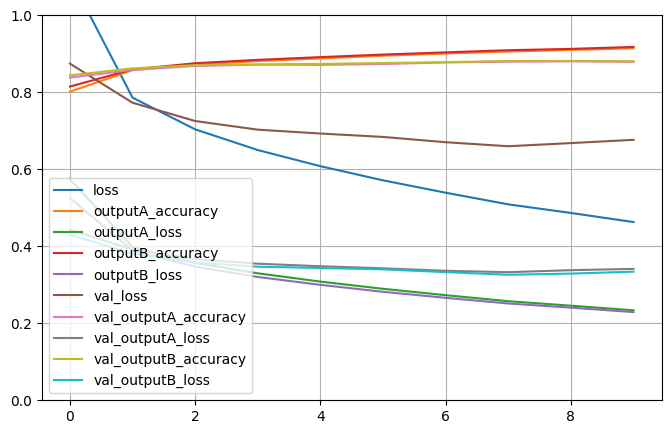

In [47]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")
plt.show()

In [48]:
yestA,yestB = model_fun.predict([Xtest,Xtest])
print(yestA.shape,yestB.shape)#salidas tipo 1 -K probabilidad de membresia a cada clase

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(10000, 10) (10000, 10)


In [49]:
scoreA = model_fun.evaluate([Xtest,Xtest],[ytest,ytest])#evaluacion
print(scoreA)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7364 - outputA_accuracy: 0.8684 - outputA_loss: 0.3713 - outputB_accuracy: 0.8740 - outputB_loss: 0.3651
[0.7324127554893494, 0.36989647150039673, 0.3617440164089203, 0.8693000078201294, 0.8741000294685364]


In [50]:
model.layers[1].get_weights()[1].shape

(50,)

In [51]:
model.layers[1].get_weights()[0].sum(axis=0).shape

(50,)

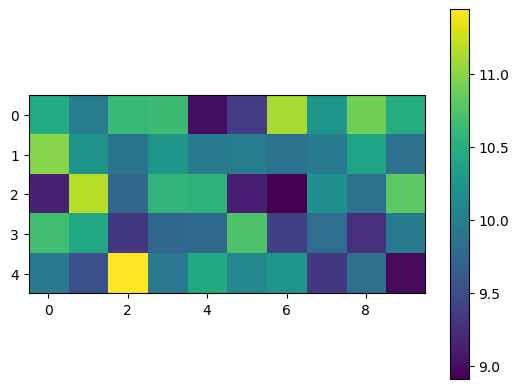

In [52]:
plt.imshow(abs(model.layers[1].get_weights()[0]).sum(axis=0).reshape(5,10))
plt.colorbar()
plt.show()